# Analysis of COVID-19 in UK, GER, FR, IT, GR and BG using API. Compare the cases and deaths across time and cumulative cases on the last date of the study. 

In [1]:
import requests
import json
import pandas as pd
import scipy
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import numpy as np
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()  
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [2]:
# make a request of COVID-19 API data for all countries and covert JSON format to pandas dataframe 
payload = {'code': 'ALL'} #  If you want to query just Greece, replace this line with {'code': 'Greece'}
URL = 'https://api.statworx.com/covid'
data = requests.post(url=URL, data=json.dumps(payload))
df = pd.DataFrame.from_dict(json.loads(data.text))
print(len(df))
df.head()

19666


,date,day,month,year,cases,deaths,country,code,population,continentExp,cases_cum,deaths_cum
0,2019-12-31,31,12,2019,0,0,Afghanistan,AF,37172386,Asia,0,0
1,2020-01-01,1,1,2020,0,0,Afghanistan,AF,37172386,Asia,0,0
2,2020-01-02,2,1,2020,0,0,Afghanistan,AF,37172386,Asia,0,0
3,2020-01-03,3,1,2020,0,0,Afghanistan,AF,37172386,Asia,0,0
4,2020-01-04,4,1,2020,0,0,Afghanistan,AF,37172386,Asia,0,0


In [3]:
# convert date column (str) to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') 

In [4]:
df = df[df['date'] >= pd.to_datetime('2020-03-01') ] 
print(len(df))
df.head()

15579


,date,day,month,year,cases,deaths,country,code,population,continentExp,cases_cum,deaths_cum
61,2020-03-01,1,3,2020,0,0,Afghanistan,AF,37172386,Asia,1,0
62,2020-03-02,2,3,2020,0,0,Afghanistan,AF,37172386,Asia,1,0
63,2020-03-08,8,3,2020,3,0,Afghanistan,AF,37172386,Asia,4,0
64,2020-03-11,11,3,2020,3,0,Afghanistan,AF,37172386,Asia,7,0
65,2020-03-15,15,3,2020,3,0,Afghanistan,AF,37172386,Asia,10,0


In [5]:
df = df.drop(['day', 'month', 'year'], axis=1)
df.head()

,date,cases,deaths,country,code,population,continentExp,cases_cum,deaths_cum
61,2020-03-01,0,0,Afghanistan,AF,37172386,Asia,1,0
62,2020-03-02,0,0,Afghanistan,AF,37172386,Asia,1,0
63,2020-03-08,3,0,Afghanistan,AF,37172386,Asia,4,0
64,2020-03-11,3,0,Afghanistan,AF,37172386,Asia,7,0
65,2020-03-15,3,0,Afghanistan,AF,37172386,Asia,10,0


In [6]:
df.dtypes 

date            datetime64[ns]
cases                    int64
deaths                   int64
country                 object
code                    object
population               int64
continentExp            object
cases_cum                int64
deaths_cum               int64
dtype: object

In [7]:
# select 6 countries and reset the index of this dataframe 
df = (df.loc[df['country'].isin(['United_Kingdom', 'Germany', 'France', 'Italy','Greece', 'Bulgaria'])]
      .reset_index()
      .drop(['index'], axis=1)
     )
df.head()

,date,cases,deaths,country,code,population,continentExp,cases_cum,deaths_cum
0,2020-03-08,2,0,Bulgaria,BG,7024216,Europe,2,0
1,2020-03-09,2,0,Bulgaria,BG,7024216,Europe,4,0
2,2020-03-12,3,1,Bulgaria,BG,7024216,Europe,7,1
3,2020-03-13,16,0,Bulgaria,BG,7024216,Europe,23,1
4,2020-03-14,8,0,Bulgaria,BG,7024216,Europe,31,1


In [8]:
df.isnull().values.any()

False

In [9]:
# convert population in millions (for visualization only)
df['population_millions']=df['population']/10000000

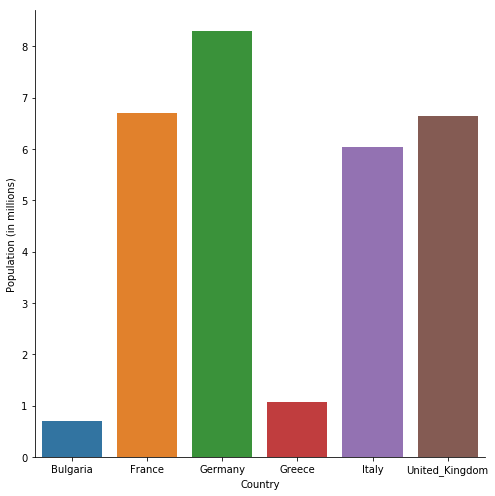

In [10]:
plot_pop=sns.catplot(x='country', y='population_millions', data= df,kind="bar", height=7)
plot_pop.set_axis_labels("Country", "Population (in millions)")  

In [11]:
df.describe()

,cases,deaths,population,cases_cum,deaths_cum,population_millions
count,517.000000,517.000000,5.170000e+02,517.000000,517.000000,517.000000
mean,1595.800774,207.282398,4.997875e+07,71799.794971,8559.123791,4.997875
std,1903.182777,294.549968,2.896318e+07,81051.805045,11622.229057,2.896318
min,-525.000000,0.000000,7.024216e+06,2.000000,0.000000,0.702422
25%,39.000000,2.000000,1.072767e+07,1652.000000,53.000000,1.072767
50%,665.000000,64.000000,6.648899e+07,23980.000000,860.000000,6.648899
75%,2931.000000,319.000000,6.698724e+07,141919.000000,17167.000000,6.698724
max,8719.000000,2004.000000,8.292792e+07,265227.000000,37048.000000,8.292792


In [12]:
df.groupby('country').mean()

,cases,deaths,population,cases_cum,deaths_cum,population_millions
country,,,,,,
Bulgaria,31.139241,1.683544,7024216.0,1052.417722,48.240506,0.702422
France,1653.386364,324.181818,66987244.0,80320.920455,13725.806818,6.698724
Germany,2037.579545,94.875000,82927922.0,100489.761364,3542.250000,8.292792
Greece,33.581395,2.011628,10727668.0,1738.325581,87.081395,1.072767
Italy,2609.852273,374.250000,60431283.0,135144.147727,17820.454545,6.043128
United_Kingdom,3013.738636,421.000000,66488991.0,103225.363636,15067.931818,6.648899


In [13]:
# define a function to plot number of cases and deaths (and their comulatives) over time for each country
def country_plot(y):
    my_tooltips = ['country', 'date', 'cases_cum', 'deaths_cum', 'deaths', 'cases']
    return alt.Chart(df).mark_line(point=True).encode(
        x='date', y = y, color='country',
        tooltip = my_tooltips
    ).properties(
        width=1000,
        height=300
    )

country_plot('cases')
# Looks like there is a data quality issue. Why in the UK at 21-May-2020 there are -525 (negative) number of cases?

alt.Chart(...)

In [14]:
country_plot('deaths')

alt.Chart(...)

In [15]:
country_plot('cases_cum')

alt.Chart(...)

In [16]:
country_plot('deaths_cum')

alt.Chart(...)

In [17]:
df.groupby('country').max()

,date,cases,deaths,code,population,continentExp,cases_cum,deaths_cum,population_millions
country,,,,,,,,,
Bulgaria,2020-05-27,91,6,BG,7024216,Europe,2460,133,0.702422
France,2020-05-27,7578,2004,FR,66987244,Europe,145555,28530,6.698724
Germany,2020-05-27,6294,315,DE,82927922,Europe,179364,8349,8.292792
Greece,2020-05-27,156,9,EL,10727668,Europe,2892,173,1.072767
Italy,2020-05-27,6557,971,IT,60431283,Europe,230555,32955,6.043128
United_Kingdom,2020-05-27,8719,1172,UK,66488991,Europe,265227,37048,6.648899


In [18]:
df_last_date = df.groupby('country').max()
df_last_date

,date,cases,deaths,code,population,continentExp,cases_cum,deaths_cum,population_millions
country,,,,,,,,,
Bulgaria,2020-05-27,91,6,BG,7024216,Europe,2460,133,0.702422
France,2020-05-27,7578,2004,FR,66987244,Europe,145555,28530,6.698724
Germany,2020-05-27,6294,315,DE,82927922,Europe,179364,8349,8.292792
Greece,2020-05-27,156,9,EL,10727668,Europe,2892,173,1.072767
Italy,2020-05-27,6557,971,IT,60431283,Europe,230555,32955,6.043128
United_Kingdom,2020-05-27,8719,1172,UK,66488991,Europe,265227,37048,6.648899


In [19]:
# percetage of cumulative cases and cumulative deaths from the population
df_last_date.loc[:,'cases_cum_percentage'] = df_last_date['cases_cum']/df_last_date['population'] * 100
df_last_date.loc[:,'deaths_cum_percentage'] = df_last_date['deaths_cum']/df_last_date['population'] * 100
# percetage of cumulative deaths from the cumulative cases
df_last_date.loc[:,'deaths_cum_percentage_cases'] = df_last_date['deaths_cum']/df_last_date['cases_cum'] * 100

In [20]:
df_last_date

,date,cases,deaths,code,population,continentExp,cases_cum,deaths_cum,population_millions,cases_cum_percentage,deaths_cum_percentage,deaths_cum_percentage_cases
country,,,,,,,,,,,,
Bulgaria,2020-05-27,91,6,BG,7024216,Europe,2460,133,0.702422,0.035022,0.001893,5.406504
France,2020-05-27,7578,2004,FR,66987244,Europe,145555,28530,6.698724,0.217288,0.042590,19.600838
Germany,2020-05-27,6294,315,DE,82927922,Europe,179364,8349,8.292792,0.216289,0.010068,4.654780
Greece,2020-05-27,156,9,EL,10727668,Europe,2892,173,1.072767,0.026958,0.001613,5.982019
Italy,2020-05-27,6557,971,IT,60431283,Europe,230555,32955,6.043128,0.381516,0.054533,14.293769
United_Kingdom,2020-05-27,8719,1172,UK,66488991,Europe,265227,37048,6.648899,0.398904,0.055721,13.968412


In [21]:
my_tooltips = ['country','cases_cum_percentage', 'deaths_cum_percentage', 'deaths_cum_percentage_cases' ]

alt.Chart(df_last_date.reset_index()).transform_fold(
    fold=['cases_cum_percentage','deaths_cum_percentage']).mark_bar().encode(
    y='country:N',
    x='value:Q',
    color='key:N',
    tooltip = my_tooltips).properties(
        width=1000,
        height=300
    )

alt.Chart(...)

In [22]:
alt.Chart(df_last_date.reset_index()).mark_bar().encode(
    y='country:N',
    x='deaths_cum_percentage_cases:Q',
    tooltip = my_tooltips).properties(
        width=1000,
        height=300
    )

alt.Chart(...)